In [849]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import Counter
import random
import copy
import math
random.seed(4)

In [850]:
def convertTxtFile2Maze(filepath):
    with open(filepath, 'r') as f:
        content = f.readlines()

    content = [x.strip() for x in content]
    data_mat = []

    for line in content:
        s = [c for c in line]
        data_mat.append(s)

    data_mat = np.array(data_mat)
    iv_data_mat = np.flip(data_mat, axis=0)
    dimension = (iv_data_mat.shape[1], iv_data_mat.shape[0])
    
    t_s_walls = []
    t_s_goalStates = []
    t_s_penaltyStates = []
    for i in range(iv_data_mat.shape[1]):
        for j in range(iv_data_mat.shape[0]):
            t_s = (i+1,j+1)
            t_sv = iv_data_mat[j][i]
            if t_sv == "1":
                t_s_walls.append(t_s)
            if t_sv == "g":
                t_s_goalStates.append(t_s)
            if t_sv == "p":
                t_s_penaltyStates.append(t_s)
    return dimension, t_s_walls, t_s_goalStates, t_s_penaltyStates

In [851]:
class Problem:

    startState = (1,1)   # (x, y) class variable shared by all instances
    movesEffects = {"L":(-1,0), "R":(+1,0), "U":(0,+1), "D":(0,-1),}

    def __init__(self, dimension=(4,3), walls=[], penaltyState=[]):
        self.dimension = dimension
        self.walls = walls
        self.goalState = (dimension[0], dimension[1])    # instance variable unique to each instance
        self.penaltyState = penaltyState
        
        self.xMin, self.xMax = 1, dimension[0]
        self.yMin, self.yMax = 1, dimension[1]        
    
    def getLegalActions(self, state):
        validMoves = []
        for k,v in self.movesEffects.items():
            result_x = state[0] + v[0]
            result_y = state[1] + v[1]
            
            isValid = True

            if (result_x, result_y) in self.walls:
                isValid = False
            if result_x < self.xMin or result_x > self.xMax:
                isValid = False
            if result_y < self.yMin or result_y > self.yMax:
                isValid = False
            if isValid == True:
                validMoves.append(k)
        if not validMoves:
            print("no legal move for {} ".format(state))
        return validMoves
    
    def move(self, state, action):
        (new_x, new_y) = (-1,-1)
        if action in self.getLegalActions(state):
            new_x = state[0] + self.movesEffects[action][0]
            new_y = state[1] + self.movesEffects[action][1]
        if (new_x, new_y) == (-1,-1):
            print("Error, invalid move!")
        return (new_x, new_y)
    
    def isGoal(self, state):
        return state == self.goalState
    
    def findPathCost(self, path):
        return len(path)
    
    def findStepCost(self, state, action):
        return 1.0


In [852]:
class SearchAgent:

    def __init__(self, p, method='bfs'):
        self.problem = p
        self.method = method
        self.frontierList = [(self.problem.startState, [], 0)] #(path end state, path list, path cost)
        self.exploredList = []
        self.visitedList = []
        self.path = []
    
    def moveChoice(self):
        if self.method == 'bfs':
            self.frontierList.sort(key=lambda x: x[2]) #sort the frontier list by path cost
            pathstep = self.frontierList.pop(0) #pop the smallest path cost item
        elif self.method == 'dfs':
            self.frontierList = sorted(self.frontierList, key=lambda x: x[2])[::-1] 
                #sort the frontier list by path cost
            pathstep = self.frontierList.pop(0)
        elif self.method == 'astar':
            min_total_cost = float(np.inf)
            min_pop_index = None
            for i in range(len(self.frontierList)):
                actual_cost = self.frontierList[i][2]
                # use manhattan distance as an estimation
                heuristic_cost = np.sqrt(np.sum(np.square(np.array(self.frontierList[i][0]) 
                                                          - np.array(self.problem.goalState))))
                total_cost = actual_cost + heuristic_cost
                if total_cost < min_total_cost:
                    min_total_cost = total_cost
                    min_pop_index = i
            pathstep = self.frontierList.pop(min_pop_index)

        return pathstep, self.frontierList 
    
    def findPaths(self, printGoal=False):

        while self.frontierList:

            pathstep, self.frontierList = self.moveChoice() 
            #different method only affect the choice of next node to explore

            s = pathstep[0] #state
            self.path = pathstep[1] #the active path

            if self.problem.isGoal(s):
                if printGoal:
                    print("{} no of steps: {}".format(method, len(path)))
                    print("Path:{}".format(path), end='\n')
                return self.path, self.visitedList  

            legalActionsList = self.problem.getLegalActions(s) # get legal moves

            self.exploredList.append(s)

            for a in legalActionsList:

                next_end = self.problem.move(s,a) #assume we take the move, what would be the future state?

                if next_end not in self.exploredList and next_end not in [x[0] for x in self.frontierList]:
                    #make sure we are not going back to explored node and no duplication in frontierList

                    if len(self.path) == 0: #make sure startState is included in the path
                        self.path.append(self.problem.startState)
                        self.visitedList.append(self.problem.startState) #for visual graph

                    next_path = copy.deepcopy(self.path)
                    next_path.append(next_end) #keep track on how did we reach this frontier node

                    self.frontierList.append((next_end, next_path, self.problem.findPathCost(next_path))) 

                    self.visitedList.append(next_end) # for visualization

        return self.path, self.visitedList
    
    def path2grid(self):
        assert(len(self.path) > 0)
        
        data = np.zeros(self.problem.dimension)
        
        for w in self.problem.walls:
            data[w[1]-1,w[0]-1] += 1.0

        for v in self.visitedList:
            data[v[1]-1,v[0]-1] += 0.2

        for pa in self.path:
            data[pa[1]-1,pa[0]-1] += 0.3
            
        data = np.flip(data,axis=0)
        
        return data

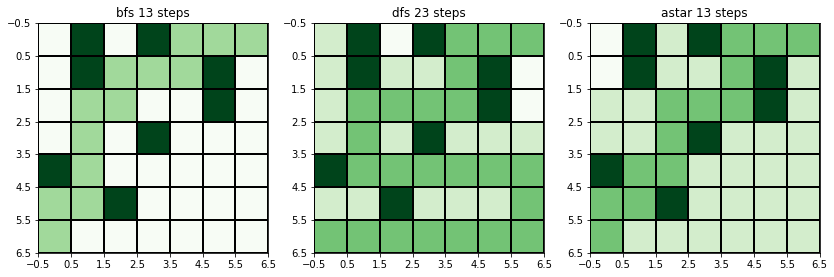

In [853]:
dimension = (7,7)
p = Problem(dimension,
            walls=[(1,3),
                   (2,6),(2,7),
                   (3,2),
                   (4,4),(4,7),
                   #(5,6),
                   (6,5),(6,6),
                  ]           
           )
searchMethodList = ['bfs','dfs','astar']

fig, axs = plt.subplots(1,len(searchMethodList), figsize=(14,6)) 

for i in range(len(searchMethodList)):
    s = SearchAgent(p, searchMethodList[i])
    path, visitedList = s.findPaths()
    data = s.path2grid()
    
    axs[i].imshow(data, cmap='Greens')

    # draw gridlines
    axs[i].set(title= str(searchMethodList[i]) + ' ' + str(len(path)) + ' steps')
    axs[i].grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    axs[i].set_xticks(np.arange(-.5, dimension[0], 1));
    axs[i].set_yticks(np.arange(-.5, dimension[1], 1));
    
plt.show()

In [854]:
####################################################################

In [924]:
def showSearchPolicy(px, sA, initialState = (1,1), title='', plotsize=(5,5)):
    
    endStateReached = False
    searchPath = []

    currentState = sA.initialState
    searchPath.append(currentState)
    counter = 0
    while not endStateReached and counter < 10000 and not px.isPenalty(currentState):
        if sA.trainMethod == 'V':
            optimalAct = sA.sValue[currentState]['optAction'] 
        else:
            optimalAct, optimalQscore = sA.getOptimalAction(currentState, offPolicyThreshold=0.0)
        #print(currentState, optimalAct)
        nextState, _ = px.move(currentState, optimalAct)

        currentState = nextState
        searchPath.append(currentState)

        if currentState in px.goalState: #once reached the goal the search ended
            endStateReached = True
        
        counter += 1

    displayRLMaze(px,sA,searchPath, title, plotsize=plotsize)

In [856]:
from matplotlib.font_manager import FontProperties

def displayRLMaze(p1, sA, visitedPath=[], title='', plotsize=(5,5)):
    font0 = FontProperties()
    font1 = font0.copy()
    font1.set_size(20)
    font1.set_weight('bold')
    alignment = {'horizontalalignment': 'center', 'verticalalignment': 'center'}
    dir2ArrowsMap = {'L':'◀','R':'►','U':'▲','D':'▼'}

    data = np.zeros([p1.dimension[1], p1.dimension[0]])

    fig, ax  = plt.subplots(1,1, figsize=plotsize) 

    for w in p1.walls:
        data[w[1]-1,w[0]-1] = 0

    for v in visitedPath:
        data[v[1]-1,v[0]-1] += 0.01

    data = np.flip(data,axis=0)

    ax.imshow(data, cmap='Greens')
    
    plotYAxisConvertor = list(np.arange(0,p1.dimension[1]))[::-1]

    for i in range(p1.dimension[0]):
        for j in range(p1.dimension[1]):        

            if (i+1,j+1) in p1.goalState:
                """
                The text plot coordination would be (0,1)
                0000
                1000
                0000
                """
                uj = plotYAxisConvertor.index(j)
                plt.text(i,uj,'◎', color='k', fontproperties=font1, **alignment)
            elif (i+1,j+1) in p1.penaltyState:
                uj = plotYAxisConvertor.index(j)
                plt.text(i,uj,'☠', color='k', fontproperties=font1, **alignment)
            elif (i+1,j+1) in p1.walls:
                uj = plotYAxisConvertor.index(j)
                plt.text(i,uj,'X', color='k', fontproperties=font1, **alignment)
            else:
                qScoreMax = -np.Inf
                MaxDir = None
                
                if sA.trainMethod == 'V':
                    qScoreMax = sA.sValue[(i+1,j+1)]['value']
                    MaxDir = sA.sValue[(i+1,j+1)]['optAction']                    
                else:
                    for keys, values in sA.qScore[(i+1,j+1)].items():
                        if values > qScoreMax:
                            qScoreMax = values
                            MaxDir = keys #{'L':0.0, 'R':0.0, 'U':0.0, 'D':0.0}
                    
                uj = plotYAxisConvertor.index(j)
                plt.text(i,uj,dir2ArrowsMap[MaxDir], color='r', fontproperties=font1, **alignment) 
                
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set(title=title)
    ax.set_xticks(np.arange(-.5, p1.dimension[0], 1));
    ax.set_yticks(np.arange(-.5, p1.dimension[1], 1));

In [1113]:
class RL_Problem():
    legalMoves = ['L','R','U','D']
    moveEffect = {'L':(-1,0), 'R':(+1,0), 'U':(0,+1), 'D':(0,-1)}
    step_reward = {}
    moveProbability = [0.8,0.1,0.1]
    
    def __init__(self, dimension = (4,3), walls = [(2,2)], penaltyState = [],
                 goalStateReward=1.0, penaltyStateReward=-1.0, global_step_cost=-0.04,
                 ):
        
        self.dimension = dimension
        self.walls = walls
        self.yMax, self.yMin = dimension[1], 1
        self.xMax, self.xMin = dimension[0], 1
        
        self.goalState = [(dimension[0], dimension[1])]
        self.penaltyState = penaltyState
        
        self.goalStateReward = goalStateReward
        self.penaltyStateReward = penaltyStateReward
        self.global_step_cost = global_step_cost
        
        self.initializeValues()
    
    def initializeValues(self):
        maze_width = self.dimension[0]
        maze_height = self.dimension[1]

        for i in range(maze_width):
            for j in range(maze_height):

                if self.isGoal((i+1,j+1)):
                    self.step_reward[(i+1,j+1)] = self.goalStateReward
                elif self.isPenalty((i+1,j+1)):
                    self.step_reward[(i+1,j+1)] = self.penaltyStateReward
                elif self.isWall((i+1,j+1)):
                    self.step_reward[(i+1,j+1)] = 0.0
                else:
                    self.step_reward[(i+1,j+1)] = self.global_step_cost

    def isGoal(self, s):
        return s in self.goalState
    
    def isPenalty(self, s):
        return s in self.penaltyState

    def isWall(self, s):
        return s in self.walls    
    
    def getPotentialMoves(self, s, a):        
        potentialMoves = [] #list of possible stataes outcome based on probability 0: 80% 1:10% 2:10%
        horizontalMoves = ['L','R']
        verticalMoves = ['U','D']
        
        #80% direction
        potentialMoves.append( (s[0] + self.moveEffect[a][0], s[1] + self.moveEffect[a][1]) )
        #10% 10%
        if a in horizontalMoves:
            a1 = verticalMoves[0]
            a2 = verticalMoves[1]
        else:
            a1 = horizontalMoves[0]
            a2 = horizontalMoves[1]
        potentialMoves.append( (s[0] + self.moveEffect[a1][0], s[1] + self.moveEffect[a1][1]) )
        potentialMoves.append( (s[0] + self.moveEffect[a2][0], s[1] + self.moveEffect[a2][1]) )   
        
        # What if there are walls/beyond max or min of the maze
        for i in range(len(potentialMoves)):
            moveSucceeded = True
            if potentialMoves[i] in self.walls:
                moveSucceeded = False
                #print("wall")
            if potentialMoves[i][0] < self.xMin or potentialMoves[i][0] > self.xMax:
                moveSucceeded = False
                #print("x error")
            if potentialMoves[i][1] < self.yMin or potentialMoves[i][1] > self.yMax:
                moveSucceeded = False
            if not moveSucceeded:
                potentialMoves[i] = s
        
        return potentialMoves
        
    
    def move(self, currentState, a, probabilistic=True):

        potentialMoves = self.getPotentialMoves(currentState, a)
        
        if probabilistic:
            r = random.random()
        else:
            r = 0.0

        if r <= self.moveProbability[0]:
            newState = potentialMoves[0]
            p = self.moveProbability[0]
        elif r > self.moveProbability[0] and r <= self.moveProbability[0] + self.moveProbability[1]:
            newState = potentialMoves[1]
            p = self.moveProbability[1]
        else:
            newState = potentialMoves[2]   
            p = self.moveProbability[2]

        return newState, p

In [1114]:
class RL_SearchAgent:
    
    qScore = {}
    sValue = {}
    e = {} #for eligibility
    sVisitCount = {} #for tracking which state to start in next episode
    offPolicyThreshold = 0.0
    trainMethod = ''

    def __init__(self, p1, alpha=0.1, gamma=0.9, initialState=(1,1), TDLamda=0.0):
        self.problem = p1
        self.alpha = alpha
        self.gamma = gamma
        self.initialState = initialState
        self.visitedPath = []
        
        assert(TDLamda >=0.0 and TDLamda <= 1.0)
        self.TDLamda = TDLamda #0:-> not use eligibility
        
        self.initialize()

    def initialize(self, reinit=False):
        maze_width = self.problem.dimension[0]
        maze_height = self.problem.dimension[1]

        for i in range(maze_width):
            for j in range(maze_height):
                if not self.problem.isWall((i+1,j+1)):
                    if reinit==False: #first time construct
                        self.qScore[(i+1,j+1)] = {'L':0.0, 'R':0.0, 'U':0.0, 'D':0.0} #for Q score
                        self.sValue[(i+1,j+1)] = {'value': 0.0, 'optAction': ''} #for value base
                        # count ordinary states only!
                        if not self.problem.isGoal((i+1,j+1)) and not self.problem.isPenalty((i+1,j+1)):
                            self.sVisitCount[(i+1,j+1)] = {'stateCount': 0, 'actionCount': 
                                                          {'L':0.0, 'R':0.0, 'U':0.0, 'D':0.0}
                                                          } #with actions
                    self.e[(i+1,j+1)] = 0.0 #e got reinit everytime a new episode starts


    def getOptimalAction(self, s, offPolicyThreshold=0.0, e=0.95, useVisitedData=False):
        
        self.offPolicyThreshold = offPolicyThreshold

        maxQ = -np.Inf 
        optimalMove = None

        temp_legalMoves = copy.deepcopy(self.problem.legalMoves)

        random.shuffle(temp_legalMoves) #to avoid directional bias

        if s not in self.problem.penaltyState and s not in self.problem.goalState:
            if random.random() < self.offPolicyThreshold: #go for random move
                if not useVisitedData:
                    di = random.randint(0, len(temp_legalMoves)-1)
                    optimalMove = temp_legalMoves[di]  
                    maxQ = self.qScore[s][optimalMove]

                    self.offPolicyThreshold = self.offPolicyThreshold*e 
                    #dimish the effect as we approach convergence
                else:
                    optimalMove = self.getUCBNextAction(s)
                    maxQ = self.qScore[s][optimalMove]
            else:
                for d in temp_legalMoves: #the normal optimal way
                    if self.qScore[s][d] > maxQ:
                        maxQ = self.qScore[s][d]
                        optimalMove = d
        else:
            # no need to goal states or penalty states to return optimal action/Qscore
            maxQ = 0.0 
            #optimalMove = None 
            optimalMove = temp_legalMoves[random.randint(0, len(temp_legalMoves)-1)] #a random act
   
        return optimalMove, maxQ

    def getExpectedUtility(self, s, a):
        
        PotentialMoves = self.problem.getPotentialMoves(s, a)

        #calculate the expected utility (prob of ending at a state x state value) for all actions
        # of the current state and update the qscore of the max utlity action of the current state
        expectedsValue = 0
        for si in range(len(PotentialMoves)):
            if PotentialMoves[si] in self.problem.goalState:
                pmU = self.problem.goalStateReward
            elif PotentialMoves[si] in self.problem.penaltyState:
                pmU = self.problem.penaltyStateReward
            else:
                #it's important to get optimal action cause that way right action utility got 
                #propagated back to previous steps
                if self.trainMethod == 'V':
                    pmU = self.sValue[PotentialMoves[si]]['value']
                elif self.trainMethod == 'Q' or  self.trainMethod == 'TD' :
                    pa, _ = self.getOptimalAction(PotentialMoves[si]) #max Q(s,a)
                    pmU = self.qScore[PotentialMoves[si]][pa]

            expectedsValue += (self.problem.moveProbability[si] * pmU)
        
        return expectedsValue
    
    def getUCBNextAction(self, s):
        #Upper Confidence Bound EXPERIMENTAL!
        buffer_const = 1000
        maxConfLevel = -np.inf
        maxAction = None 
        for a, ar in self.sVisitCount[s]['actionCount'].items():
            n = ar+1
            avgReward = self.qScore[s][a]/(n) + buffer_const #make sure reward is pos
            confLevel = np.sqrt(((3*np.log(n))/(2*avgReward)))
            if confLevel > maxConfLevel:
                maxConfLevel = confLevel
                maxAction = a
        return a
    
    def getNewInitialState(self, method='minConfidence'):
        if method == 'minConfidence':
            # get the least visited a chance!
            s = sorted(s1.sVisitCount.items(), key=lambda kv: kv[1]['stateCount'])[0][0]
        elif method == 'random':
            #randomized nextState
            s = random.choice(list(self.qScore.items()))[0]
            while (s in self.problem.goalState 
                   or s in self.problem.penaltyState):
                s = random.choice(list(self.qScore.items()))[0] #until it is a valid state
        else:
            s = self.initialState
        return s
    
    def trainModelbyTemporalDifference(self, epoche=1000, offPolicyThreshold=0.0):
        """
        This method used the step by step movement idea to update Qscore by simulating an actual movements
        The idea was illustrated in this video: https://www.youtube.com/watch?v=bHeeaXgqVig
        """
        self.trainMethod = 'TD'

        deltaQscoreHist = []  
        tmp_deltaList = []
        
        currentState = self.initialState
        self.visitedPath.append(currentState)
        
        alpha = self.alpha #notice how change in learning rate can affect the model convergence performance
        
        for e in range(epoche):
            
            self.initialize(reinit=True) #all e has to be reinitialized when we restart an episode cycle
            endStateReached = False

            #alpha = 1./(e_t+1) 
            #alpha = 0.99*alpha #diminish alpha
            
            while not endStateReached:
                #get the optimal action, it could be off policy if r < offPolicyThreshold
                OptimalAct, OptimalQscore = self.getOptimalAction(currentState, offPolicyThreshold,
                                                                 useVisitedData=False)
                self.sVisitCount[currentState]['stateCount'] += 1 #include state count update
                self.sVisitCount[currentState]['actionCount'][OptimalAct] += 1 #include state count update
                
                #sampling and sumulation to get to convergence
                nextState, p = self.problem.move(currentState, OptimalAct) #probabilistic TRUE default
                
                _, NextStateExpectedQscore = self.getOptimalAction(nextState, offPolicyThreshold=0.0)
                
                # Since we use sampling, we do not need to calculate the expected values
                #NextStateExpectedQscore = self.getExpectedUtility(currentState, OptimalAct)
                
                ### the key formulas for error
                deltaQscore = (self.problem.step_reward[nextState] + 
                               self.gamma * NextStateExpectedQscore - OptimalQscore)
                ###
                self.e[currentState] += 1 #+1 on eligibility after leaving the state

                for es in list(self.qScore.keys()): #loop thru all the states

                    ### the update formula
                    self.qScore[es][OptimalAct] += (alpha * deltaQscore * self.e[es])
                    ###

                    self.e[es] = self.TDLamda * self.gamma * self.e[es] 
                    #note that if TDLamda ==0 only last visited state will have e==1 and updated => TD(0)
                    #if TDLamda > 0 then it is in fact TD(1) which is a K-step estimator while TD(0) is only 1 step

                if nextState in self.problem.goalState or nextState in self.problem.penaltyState: 

                    currentState = self.getNewInitialState()                          
                    endStateReached = True
                    #e_t += 1
                else:
                    currentState = nextState
                
                if len(tmp_deltaList) > 100:
                    #% keep a record of the average of abs delta
                    deltaQscoreHist.append(np.mean(np.absolute(tmp_deltaList))) 
                    tmp_deltaList = []
                else:
                    tmp_deltaList.append(deltaQscore)
                self.visitedPath.append(nextState)
                
        #note that in RL path is not exactly the most important thing, policy IS!        
        return self.visitedPath, deltaQscoreHist
        

    def trainModelBellEquationQ(self, epoche=10):
        """
        This method update all Qscore together at each time interval. There will be no path to return.
        https://classroom.udacity.com/courses/ud600/lessons/4100878601/concepts/6512308860923
        This method use 《Qscore》 which stored in state/action pair and that a max of those pair hase to be
        searched out often. While values/utility store only the max state,value pair.
        """ 
        self.trainMethod = 'Q'
        Qscore_temp = copy.deepcopy(self.qScore)  
    
        for e in range(epoche):
            all_states =  list(Qscore_temp.keys())      # Python 3; use keys = d.keys() in Python 2
            random.shuffle(all_states)
            for s in all_states:
                
                for a in self.problem.legalMoves: #loop thru all possible actions
                
                    expectedQscore = self.getExpectedUtility(s, a)
 
                    ### key formula for Qscore: note that we rely on getOptimalMove to get the max 
                    Qscore_temp[s][a] = self.problem.step_reward[s] + self.gamma*expectedQscore
                
            self.qScore = copy.deepcopy(Qscore_temp) #update all Qscore together
            
        return
    
    def trainModelBellEquationV(self, epoche=10):
        """
        This method update all Value together at each time interval. There will be no path to return.
        https://classroom.udacity.com/courses/ud600/lessons/4100878601/concepts/6512308860923
        This method use Value which store only the best value with action.
        """ 
        self.trainMethod = 'V'
        sValue_temp = copy.deepcopy(self.sValue)          

        for e in range(epoche):
            all_states =  list(sValue_temp.keys())      # Python 3; use keys = d.keys() in Python 2
            random.shuffle(all_states)
            for s in all_states:
                
                maxExpectedsValue = -np.Inf
                maxExpectedsAction = None
                
                for a in self.problem.legalMoves: #loop thru all possible actions

                    expectedsValue = self.getExpectedUtility(s, a)
                    
                    if expectedsValue > maxExpectedsValue:
                        maxExpectedsValue = expectedsValue
                        maxExpectedsAction = a
                               
                ### the update formula using the MAX expected Qscore 
                sValue_temp[s]['value'] = self.problem.step_reward[s] + self.gamma*maxExpectedsValue
                sValue_temp[s]['optAction'] = maxExpectedsAction
                ###

            self.sValue = copy.deepcopy(sValue_temp) #update all values together
            
        return    

In [1115]:
############### The Problem ######################
p1 = RL_Problem(dimension = (7,7), 
                walls=[(1,3),
                       (2,6),(2,7),
                       (3,2),
                       (4,4),(4,7),
                       #(5,6),
                       (6,5),(6,6)],
                penaltyState = [(1,4),(7,4)], goalStateReward=+3.0, 
                penaltyStateReward=-1.0,global_step_cost=-0.04) 

#p2 = RL_Problem(dimension = (4,3), 
#                walls=[(2,2)],
#                penaltyState = [(4,2)], goalStateReward=1.0, 
#                penaltyStateReward=-1.0,global_step_cost=-0.04,
#                ) 

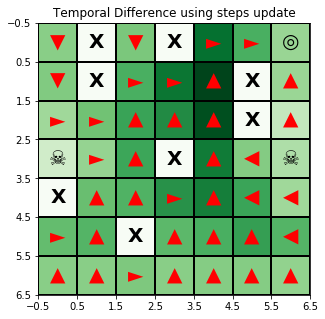

In [1119]:
################# Method 1: Temporal Difference ########################
visitedPath = []
TDLamda = 0.6 # 0-> TD(0) not use eligibility ; (1) 1-> use eligibility K steps 
s1 = RL_SearchAgent(p1, alpha = 0.07, gamma = 0.9, initialState = (1,1), TDLamda=TDLamda)

visitedPath, QscoreDiffHist = s1.trainModelbyTemporalDifference(epoche=600, offPolicyThreshold=0.8)        
displayRLMaze(p1, s1, visitedPath,'Temporal Difference using steps update')

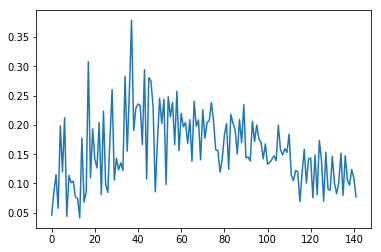

In [1120]:
plt.plot(QscoreDiffHist)
#len(QscoreDiffHist)

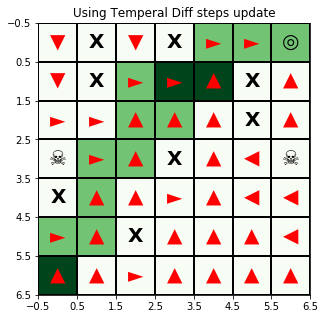

In [1125]:
showSearchPolicy(p1, s1, title='Using Temperal Diff steps update')

In [1126]:
s2 = RL_SearchAgent(p1, gamma=0.90, initialState = (1,1))

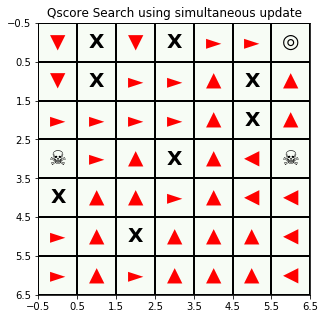

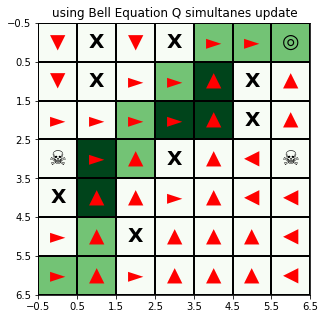

In [1127]:
################ Method 2: Bell Equation using Q ########################
s2.trainModelBellEquationQ(epoche=100) 
#since we update all possible states, we might not need off policy in this case
displayRLMaze(p1, s2, [],'Qscore Search using simultaneous update')
# Note that there is no path in this concept because all states are updated in an epoch 

showSearchPolicy(p1, s2, title='using Bell Equation Q simultanes update')

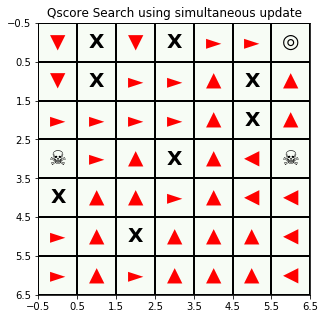

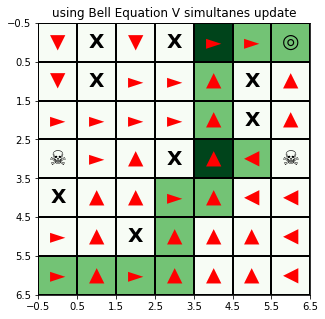

In [1128]:
################ Method 3: Bell Equation using V ########################
s2.trainModelBellEquationV(epoche=100) 
#since we update all possible states, we might not need off policy in this case
displayRLMaze(p1, s2, [],'Qscore Search using simultaneous update')
# Note that there is no path in this concept because all states are updated in an epoch 

showSearchPolicy(p1, s2, title='using Bell Equation V simultanes update')

### Learning Summary ###
<ul>
<li>BFS, DFS and Astar Search are basically planning algorithm. Everything has to be known in advance before the agent actually takes commitment to move. Reinforcement learning however assumes a discovery mode where rewards and actions are not available to be seen beyond the current stage. The agent has to explore the environment by itself.
    
<li>Compared to BFS, DFS, Astar Search etc, Reinforcement Learning usually takes a longer time to find a "policy". But once a policy is found, it can almost solve any solution on the maze. And there is no need to do additional training once a policy is identified as the policy is memorized in the qScore/Values. However for search algorithms, every time when there is a change on the initial state, the search algo has to be redo to find the optimal path again. 
    
<li>Here for RL we are comparing 3 methods:
<OL>
    <LI>Temporal differences
    <LI>Bellman Equation using Q(s,a) scores
    <LI>Bellman Equation using V(s) scores
</OL>
    
<li>for RL in general, it is sometimes quite difficult to efficiently propagate utility values from a single state to others if the maze is big. Consider a maze of 7x7, TD method took a several a few hundreds or even a thousand of epoches (from initial state to goal) to train the model until it stablize (ie wont give random results). I found that shuffling the order of list of actions together with offpolicy method would help for TD. For Bellman equation, i used random states and it seems that works okay too.
    
<li>Temporal difference, which is taught in youtube and uses a learning rate approach to update the difference between expected Qscore and the current Qscore out to be quite reliable. The qScore were updated using a step by step simulation approach. The qScore of a (state, action) will continue to update its value every time it is visited. However the propagation takes time and it could easily take up thousands of epoche (one complete trial from the random starting state to goal state) to train. The agent need time to eventually find its way to goal state and it can only propagate back the utility if it revisits the path states several times which takes a 7x7 maze long time to train. Also this method used simulation instead of calculation to take care of the expected value of probabilistic moves part and because of this, the true qScore takes even a longer time to converge because it has to explore all different options of actions leading to different results many times PLUS having to experience the probabilistic nature of the model.
    
<li>Learning rate for TD cannot be too high otherwise, it could overshot the convergence point.
    
<li>TD(0) is actually a one step estimator while TD(1) is a K-step estimator. TD(1) is very efficient in terms of propagating utility or reward values back. However, a random path of sample data could easily affect the values of TD(1) estimation which causes high variance. TD(0) only looks to the value of the next state and is relatively more stable as other sample paths are less likely to single-handedly affect value of a state in TD(0). But TD(0) takes longer time to propagate.
    
<li>Later on I learned a method using eligibility to update the Qscore/Values/Utitlity of states, I used it and implemented it as an optional parameter to turn on and off in Method 1. It turned out to be working quite well. The propagation seems faster. I guess mainly because the eligibility force updates to affect all visited path instead of just the surrounding neighboring part in one step. Thus making it faster to converge. Only a few hundreds of epoche is needed in this case. Note that the use of eligibility also implies that we need to update the alpha based on the time step (depending on how we structure the program, t could be different from e).
    
<li>Seems that an off policy threshold of about 0.1-0.2 is the best for Method 1. Note that we introduce off policy only when it is simulating the choice of next state. We dont do that when we calculate the qScore for a given state and identified next action. This method allow the utility to keep track of a discounted record of reward a previous state contributed to the new state as new state info are updated not just to the new state but also on all previous states where only visited states have eligibility.
    
<li>A few different trials were made to implement Bell Equation. There are 3 forms of bell equation here I just tried Q and V. Once it is done it is fairly fast in terms of converging. After about hundred rounds of epoches (update all states once), the policy takes shape. Method consider the expected utility of different moves in the calculation of utlility while method assume just the state it ended in and allow probabilitistic outcome when doing the simulation so that the ultimate trained values would take into accounts of the probabilistic nature of the moves. It also update all states given a time period and is not taking a step approach. Because of these, the whole process seems to converge much faster. Compare to method two, method one is more uncertain and hence takes longer time to exploit all possibilities not to mention to allow values to propagate back efficiently.
    
<li>Q and V both produces similar results.
</ul>

In [1129]:
#################### JUST FOR FUN ####################
t_s_dim, t_s_walls, t_s_goalStates, t_s_penaltyStates = convertTxtFile2Maze('maze1.txt')

pbig = RL_Problem(dimension = t_s_dim, walls=t_s_walls,
                  penaltyState = t_s_penaltyStates, goalStateReward=+5.0, 
                  penaltyStateReward=-5.0,global_step_cost=-0.04) 

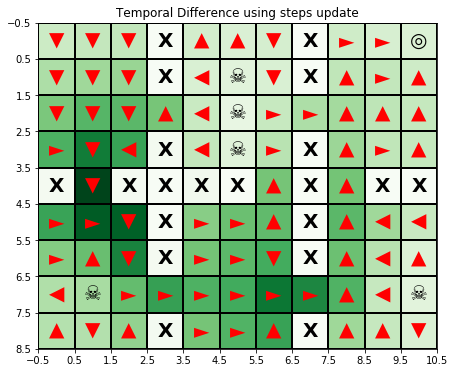

In [1133]:
################# Method 1: Temporal Difference ########################
visitedPath1 = []
TDLamda1 = 0.6 # 0-> TD(0) not use eligibility ; (1) 1-> use eligibility K steps 
sbig = RL_SearchAgent(pbig, alpha = 0.04, gamma = 0.9, initialState = (1,9), TDLamda=TDLamda)

visitedPath1, QscoreDiffHist1 = sbig.trainModelbyTemporalDifference(epoche=5000, offPolicyThreshold=0.8)        
displayRLMaze(pbig, sbig, visitedPath1,'Temporal Difference using steps update', plotsize=(8,6))

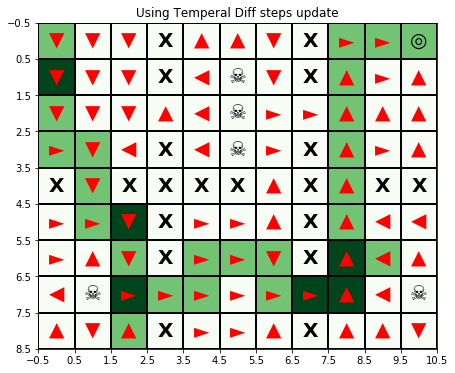

In [1135]:
showSearchPolicy(pbig, sbig, title='Using Temperal Diff steps update', plotsize=(8,6))

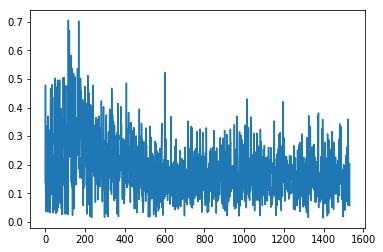

In [1136]:
plt.plot(QscoreDiffHist1)